In [15]:
import sys
sys.path.insert(0,'../src')
from v0 import *

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import shapely
import fiona
import geopandas as gpd

from sklearn.manifold import TSNE

In [3]:
STREET_SHAPE_FOLDER = '/home/adelsondias/Downloads/newcastle_streets/'
LSOA_SHAPE_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/shape/Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales/'
DATA_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/data_30days/'

## Street shape

In [4]:
lines = gpd.read_file(STREET_SHAPE_FOLDER+'newcastle_streets.shp')
points = gpd.read_file(STREET_SHAPE_FOLDER+'newcastle_points.shp')

In [9]:
print(lines.columns.values)
print(points.columns.values)

['osm_id' 'name' 'highway' 'waterway' 'aerialway' 'barrier' 'man_made'
 'z_order' 'other_tags' 'geometry']
['osm_id' 'name' 'barrier' 'highway' 'ref' 'address' 'is_in' 'place'
 'man_made' 'other_tags' 'geometry']


In [26]:
lines = lines[(lines['highway']!='') & (lines['highway']!='unclassified')]
lines['highway'].value_counts().head(20)

residential       4624
footway           3085
service           2749
tertiary           424
primary            395
cycleway           269
secondary          256
steps              209
pedestrian         193
trunk              175
path               134
trunk_link         118
track              102
motorway_link       38
motorway            36
bridleway           28
secondary_link      25
primary_link        22
road                18
construction        16
Name: highway, dtype: int64

In [23]:
points = points[points['highway']!='']
points['highway'].value_counts().head(10)

bus_stop             1430
traffic_signals       284
crossing              234
mini_roundabout        92
turning_circle         85
give_way               26
motorway_junction      11
elevator                7
speed_camera            2
street_lamp             1
Name: highway, dtype: int64

## LSOA shape

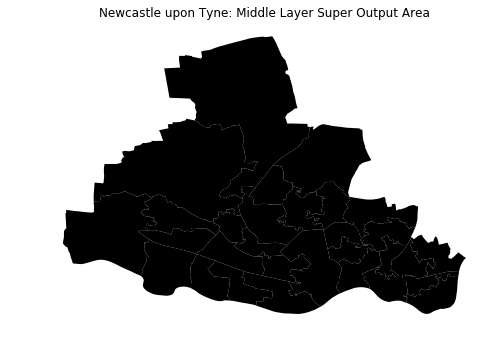

In [32]:
lsoa = gpd.read_file(LSOA_SHAPE_FOLDER+'Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales.shp')
lsoa = lsoa[lsoa['msoa11nm'].str.contains('Newcastle upon Tyne')]
lsoa = lsoa.to_crs(fiona.crs.from_epsg(4326))
lsoa.crs = {'init': 'epsg:4326', 'no_defs': True}


fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7,5))
lsoa.plot(ax=axes,color='black')
plt.axis('off')
plt.title('Newcastle upon Tyne: Middle Layer Super Output Area')
plt.tight_layout()
if False:
    plt.savefig(DATA_FOLDER+'plots/mlsoa_newcastle.svg', format='svg', dpi=600)

Filtering lines and points within LSOA of Newcastle Upon Tyne

In [13]:
lines = gpd.sjoin(lines, lsoa, how='inner' ,op='intersects')[lines.columns]
points = gpd.sjoin(points, lsoa, how='inner' ,op='intersects')[points.columns]

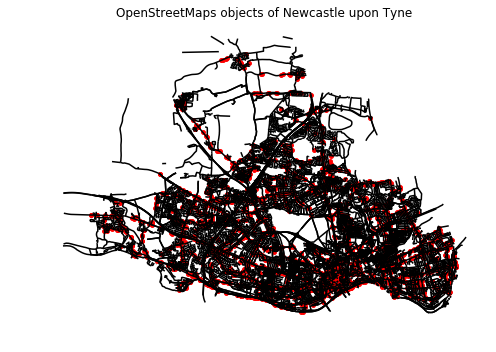

In [33]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7,5))
lines.plot(ax=axes,color='black')
points.plot(ax=axes,color='red',markersize=15)
plt.axis('off')
plt.title('OpenStreetMaps objects of Newcastle upon Tyne')
plt.tight_layout()
if False:
    plt.savefig(DATA_FOLDER+'plots/osm_newcastle_objects.svg', format='svg', dpi=600)

## Sensors data

In [17]:
metadata = pd.read_csv(DATA_FOLDER+'sensors.csv')

# spatial parsing - geometry column
metadata = gpd.GeoDataFrame(metadata[['name','type','active','lon','lat']],
                        geometry=[shapely.geometry.Point(xy) for xy in zip(metadata['lon'], metadata['lat'])], 
                        crs={'init': 'epsg:4326'}).to_crs(fiona.crs.from_epsg(4326))

metadata = gpd.sjoin(metadata, lsoa, how='inner' ,op='intersects')[['name','type','active','lon','lat','geometry']]
metadata = metadata.set_index('name')
print(metadata.shape)
metadata.head()

(281, 5)


,type,active,lon,lat,geometry
name,,,,,
new_new_emote_2602,Air Quality,True,-1.618485,54.977193,POINT (-1.618485 54.97719300000001)
eml_sensors_171702,Weather,True,-1.623670,54.972659,POINT (-1.62367 54.972659)
BMS_Armstrong.Armstrong;KRBlrOATTrndOATTKinG (OAT King George Trend_MOM),Environmental,True,-1.617460,54.978180,POINT (-1.61746 54.97818)
new_new_emote_1902,Air Quality,True,-1.621543,54.973455,POINT (-1.62154347697917 54.9734549487624)
new_new_emote_1908,Air Quality,True,-1.623102,54.972139,POINT (-1.62310237397882 54.9721388049708)


## Spatial features extraction

In [27]:
osm_df = osm_features(lines, points, metadata, 
                     conf={
                         'method':'distance', 
                         'lines':['primary','trunk','motorway','construction','residential'], 
                         'points':['traffic_signals','crossing','bus_stop']}
)

In [29]:
osm_df.to_csv(DATA_FOLDER+'street_features_newcastle.csv')
osm_df.head()

,primary,trunk,motorway,construction,residential,traffic_signals,crossing,bus_stop
new_new_emote_2602,225.717038,176.034687,158.168053,127.783274,14978.857286,332.048433,8748.892994,1364.906281
eml_sensors_171702,792.636134,90.258667,77.092709,424.312261,567.786100,886.980140,777.486146,573.982057
BMS_Armstrong.Armstrong;KRBlrOATTrndOATTKinG (OAT King George Trend_MOM),171.268788,216.250195,200.024000,109.403165,1692.565624,384.710844,694.183584,1657.698646
new_new_emote_1902,29231.283686,101.760783,90.177730,227.538451,647.791622,3354.223106,22125.309242,770.608351
new_new_emote_1908,1741.911422,87.445773,76.632429,328.685928,595.704240,1857.718698,1396.863499,680.933678
